# Phase Estimation of the ANNNI model through QML

In [1]:
from PhaseEstimation import annni, vqe, qcnn, anomaly_detection

### ANNNI model
The ANNNI model describes a spin system with competing interactions. Its Hamiltonian is given by:
$$ H =   J \sum_{i=1}^{N} \sigma_x^i\sigma_x^{i+1} - \kappa \sigma_x^{i}\sigma_x^{i+2} + h \sigma_z^i$$
where:
* $\sigma_a^i$ are the Pauli matrices acting on the $i$-th spin ($a \in \{x, y, z\}$)
* $J$ is the nearest-neighbor coupling constant, which we set to $1$ without any loss of generality
* $\kappa$ constrols the next-nearest-neighbor interaction
* $h$ represents the transverse magnetic field

Additionally, we assume open boundary conditions and consider only positive $\kappa$ and $h$.

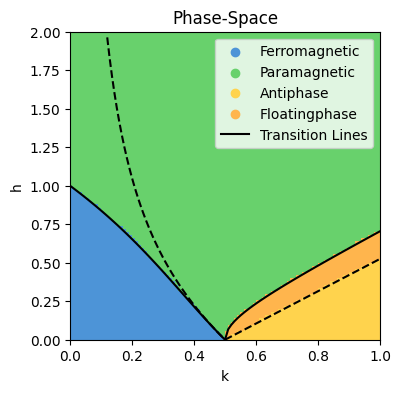

In [2]:
annni.show_phases(side = 100)

The competition between nearest-neighbor ($J$) and next-nearest-neighbor ($\kappa$) interactions introduces *magnetic frustration*, leading to a complex phase diagram consisting of three phases, separated by two second-order phase transitions:  

- **Ferromagnetic (FM) phase**: Spins align along the field direction, dominant at low frustration ($\kappa < 0.5$). The transition to the **paramagnetic (PM) phase** occurs at:  
  $$ h_I(\kappa) \approx \frac{1 - \kappa}{\kappa} \left(1 - \sqrt{\frac{1 - 3 \kappa + 4 \kappa^2 }{1 - \kappa}} \right). $$  

- **Antiphase (AP) phase**: Characterized by a repeating four-spin pattern, appearing for high frustration ($\kappa > 0.5$). The transition from the paramagnetic phase follows:  
  $$ h_C(\kappa) \approx 1.05 \sqrt{(\kappa - 0.5) (\kappa - 0.1)}. $$  

- **Multicritical Point**: The special case $\kappa = 0.5$ marks a transition between these regimes.  

Additional numerical studies suggest other features, though they remain unconfirmed:  

- A **Berezinskii–Kosterlitz–Thouless (BKT) transition**, potentially creating an intermediate *floating phase* between the PM and AP phases:  
  $$ h_{BKT}(\kappa) \approx 1.05 (\kappa - 0.5). $$  

- The **Peschel-Emery (PE) line**, an exactly solvable disorder line:  
  $$ h_{PE}(\kappa) \approx \frac{1}{4\kappa} - \kappa. $$  

### VQE
The QML models used for phase detection take as input the ground states of the ANNNI model at different values of $h$ and $\kappa$. To obtain these ground states, we use the Variational Quantum Eigensolver (VQE), which leverages the Rayleigh-Ritz variational principle to approximate the lowest-energy states of the system.  

**Goal**  

Given the Hamiltonian $H(\kappa, h)$, the objective is to find the set of parameters $\vec{\theta}$ that minimizes the energy:  

$$E(\theta) = \frac{\langle \psi(\theta)|H(\kappa, h)|\psi(\theta)\rangle}{\langle\psi(\theta)|\psi(\theta)\rangle}$$  

where $\psi(\theta)$ is the output state of the quantum circuit $U(\theta)$ before measurement, defined as:  

$$ \psi(\theta) \equiv U(\theta)|0\rangle^{\otimes N}. $$  

In [3]:
n_qubit = 8     # Number of qubits
side = 20       # Discretization of the phase space
n_iteration = 2 # Depth of the circuit, number
                # of iteration of the block ansatz

vqe_model = vqe.Vqe(n_qubit = n_qubit, side = side, n_iteration = n_iteration)
print(vqe_model)

VQE Class:
  N : 8
  side : 20
  Circuit:
0: ──H─╭●──RY(0.00)──────────────────────────────────────────────────────────────||──H─╭●──RY(8.00)
1: ──H─╰X─╭●─────────RY(1.00)────────────────────────────────────────────────────||──H─╰X─╭●───────
2: ──H────╰X────────╭●─────────RY(2.00)──────────────────────────────────────────||──H────╰X───────
3: ──H──────────────╰X────────╭●─────────RY(3.00)────────────────────────────────||──H─────────────
4: ──H────────────────────────╰X────────╭●─────────RY(4.00)──────────────────────||──H─────────────
5: ──H──────────────────────────────────╰X────────╭●─────────RY(5.00)────────────||──H─────────────
6: ──H────────────────────────────────────────────╰X────────╭●─────────RY(6.00)──||──H─────────────
7: ──H──────────────────────────────────────────────────────╰X─────────RY(7.00)──||──H─────────────

────────────────────────────────────────────────────────────────────||─┤ ╭<𝓗>
───RY(9.00)─────────────────────────────────────────────────────────||─┤ ├<𝓗>
─

In [4]:
n_epoch = 1000  # Number of epochs in the iterative algorithm
lr      = 1e0 # Learning rate

vqe_model.train_all(n_epoch = n_epoch, lr = lr, atol=0.01)

### QCNN

Quantum Convolutional Neural Networks (QCNNs) are a class of quantum circuits inspired by their classical counterparts, Convolutional Neural Networks (CNNs). Like CNNs, QCNNs aim to learn representations from input data by leveraging its local properties. In this implementation, these local properties correspond to interactions between neighboring spins.  

A QCNN consists of three main components:  

- **Convolution layers**: Alternating unitaries are applied to pairs of neighboring spins.  
- **Pooling layers**: Half of the qubits are measured, and based on the measurement outcome, different rotations are applied to the remaining qubits.  
- **Fully connected layer**: After alternating convolution and pooling layers, a final unitary operation is applied to the remaining qubits.  

  0%|          | 0/400 [00:00<?, ?it/s]

Inizialization: k: 1.00 | h: 2.00: 100%|██████████| 400/400 [00:44<00:00,  8.98it/s]


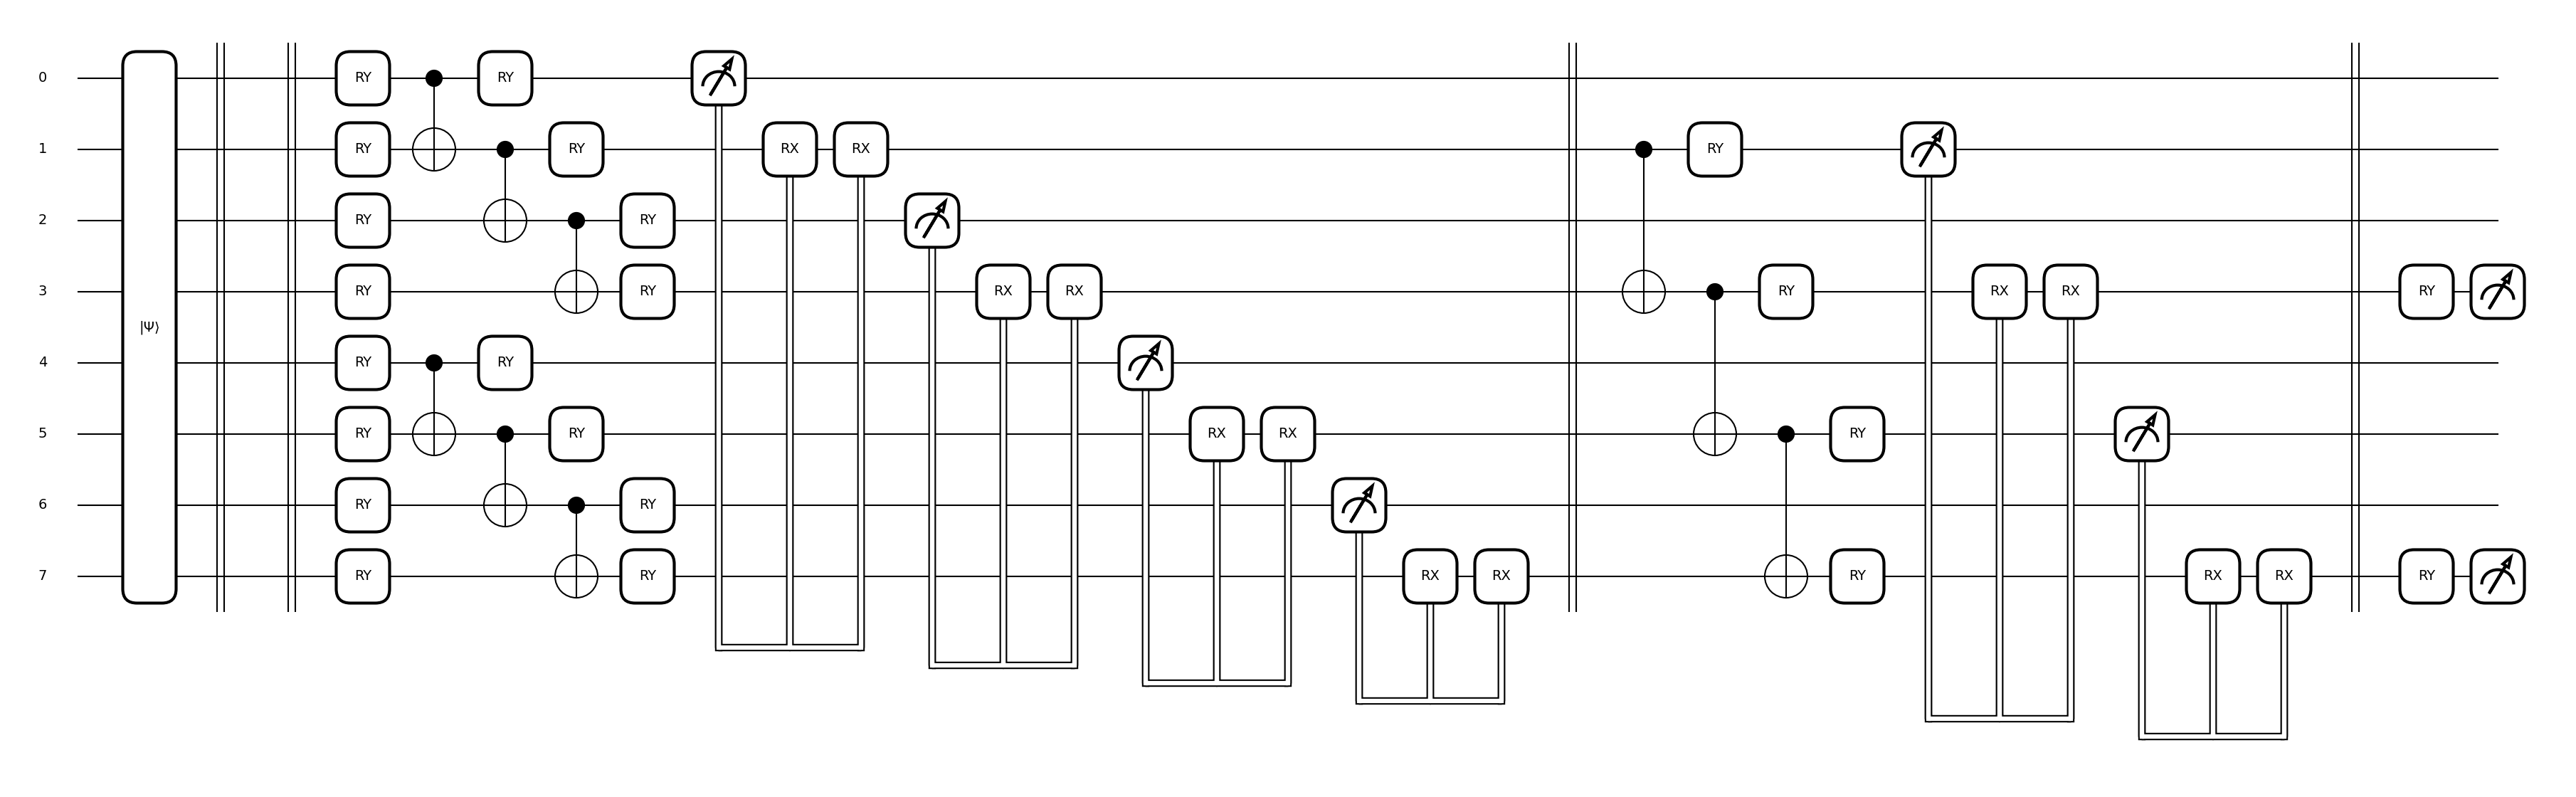

In [5]:
qcnn_model = qcnn.Qcnn(n_qubit = n_qubit,
                       side = side, 
                       vqeclass = vqe_model # VQE class for the input states
                                            # alternatively if left undefined
                                            # states will be obtained from 
                                            # diagonalization of the Hamiltonian
            )

qcnn_model.show(mpl=True)

The model outputs the probability $p_j(\kappa, h)$ of the system being in one of the three phases: **ferromagnetic, paramagnetic, or antiphase**. These probabilities are determined by measuring the two output qubits in the computational basis. Specifically:  

- $p_j(\kappa, h)$ is the probability of obtaining the states $\vert 01 \rangle$, $\vert 10 \rangle$, or $\vert 11 \rangle$, corresponding to the three physical phases.  
- The state $\vert 00 \rangle$ does not correspond to any known phase in the training set and is treated as a **garbage class**.  

The training is performed by minimizing the **Cross Entropy loss** on the output probabilities, applying a sharpening operation using a temperature factor $T$:

**Cross Entropy Loss:**  
   $$
   L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j} y_j^{\frac1T} \log \tilde{p}_j
^\frac1T   $$

Where $y_j$ represents the true one-hot encoded labels for the three phases. 


In [6]:
n_epoch = 300  # Number of epochs of the training process
lr      = 3e-1 # Learning rate of the optimizer
T       = .1   # Temperature factor

qcnn_model.train(n_epoch = n_epoch, lr = lr, T = T)

LOSS: 0.0146: 100%|██████████| 300/300 [00:07<00:00, 41.98it/s]


Accuracy: 98.00%


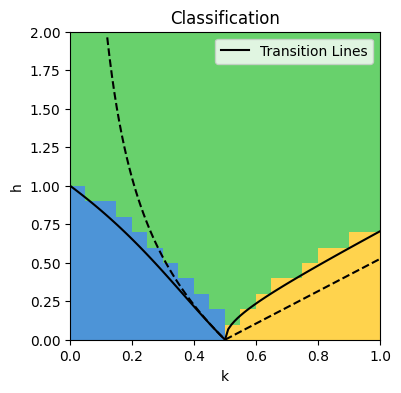

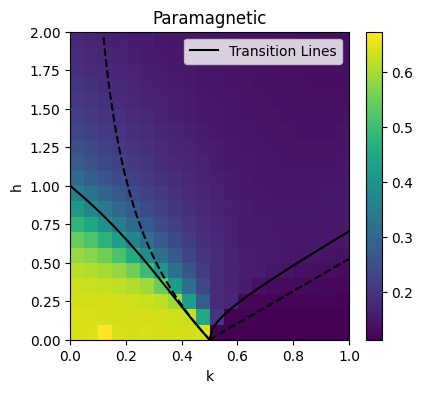

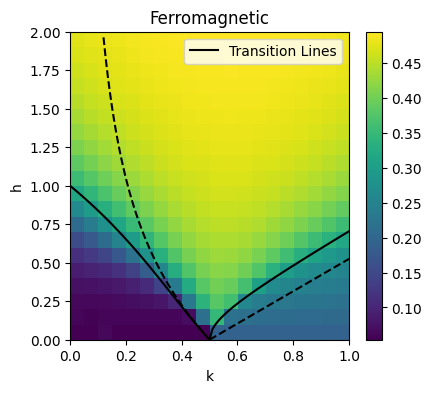

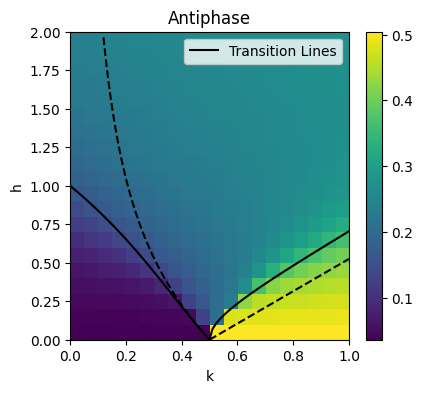

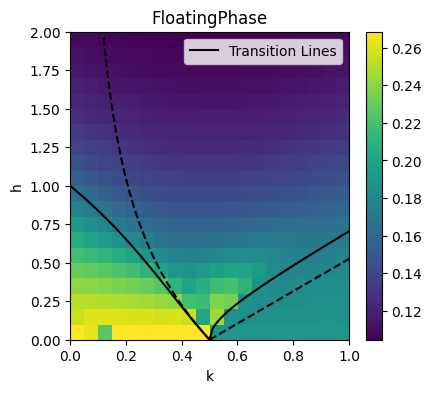

Array([[0.6394095 , 0.05375921, 0.03829826, 0.2685331 ],
       [0.64436123, 0.05969286, 0.04042123, 0.25552469],
       [0.63898979, 0.06305375, 0.04626523, 0.25169131],
       ...,
       [0.1343966 , 0.48038046, 0.27113661, 0.11408631],
       [0.13321794, 0.48356537, 0.27186591, 0.1113507 ],
       [0.13215267, 0.4863147 , 0.27263582, 0.10889698]], dtype=float64)

In [7]:
qcnn_model.predict() # Inspect the QCNN classification output on the whole phase space

### Anomaly Detection

The Quantum Anomaly Detection corresponds to the quantum version of the Auto-Encoder in which only the forward part is trained.

The training process for this architecture follows these steps:

1. **Selection of Training Event:**  
   A single quantum state is selected as the training event.

2. **Compression Objective:**  
   The training is performed to achieve the compression of the selected quantum state. This is done by minimizing the following loss function, known as the *compression score*:
   $$\mathcal{C} = \frac{1}{2}\sum_{j\in q_T} (1-\left<Z_j\right>)$$
   where $q_T$ refers to the set of trash qubits, which make up $N/2$ of the total.
   
   By doing so, all the information of the input quantum state is compressed in the remaining non-measured qubits.


Inizialization: k: 1.00 | h: 2.00: 100%|██████████| 400/400 [00:32<00:00, 12.18it/s]


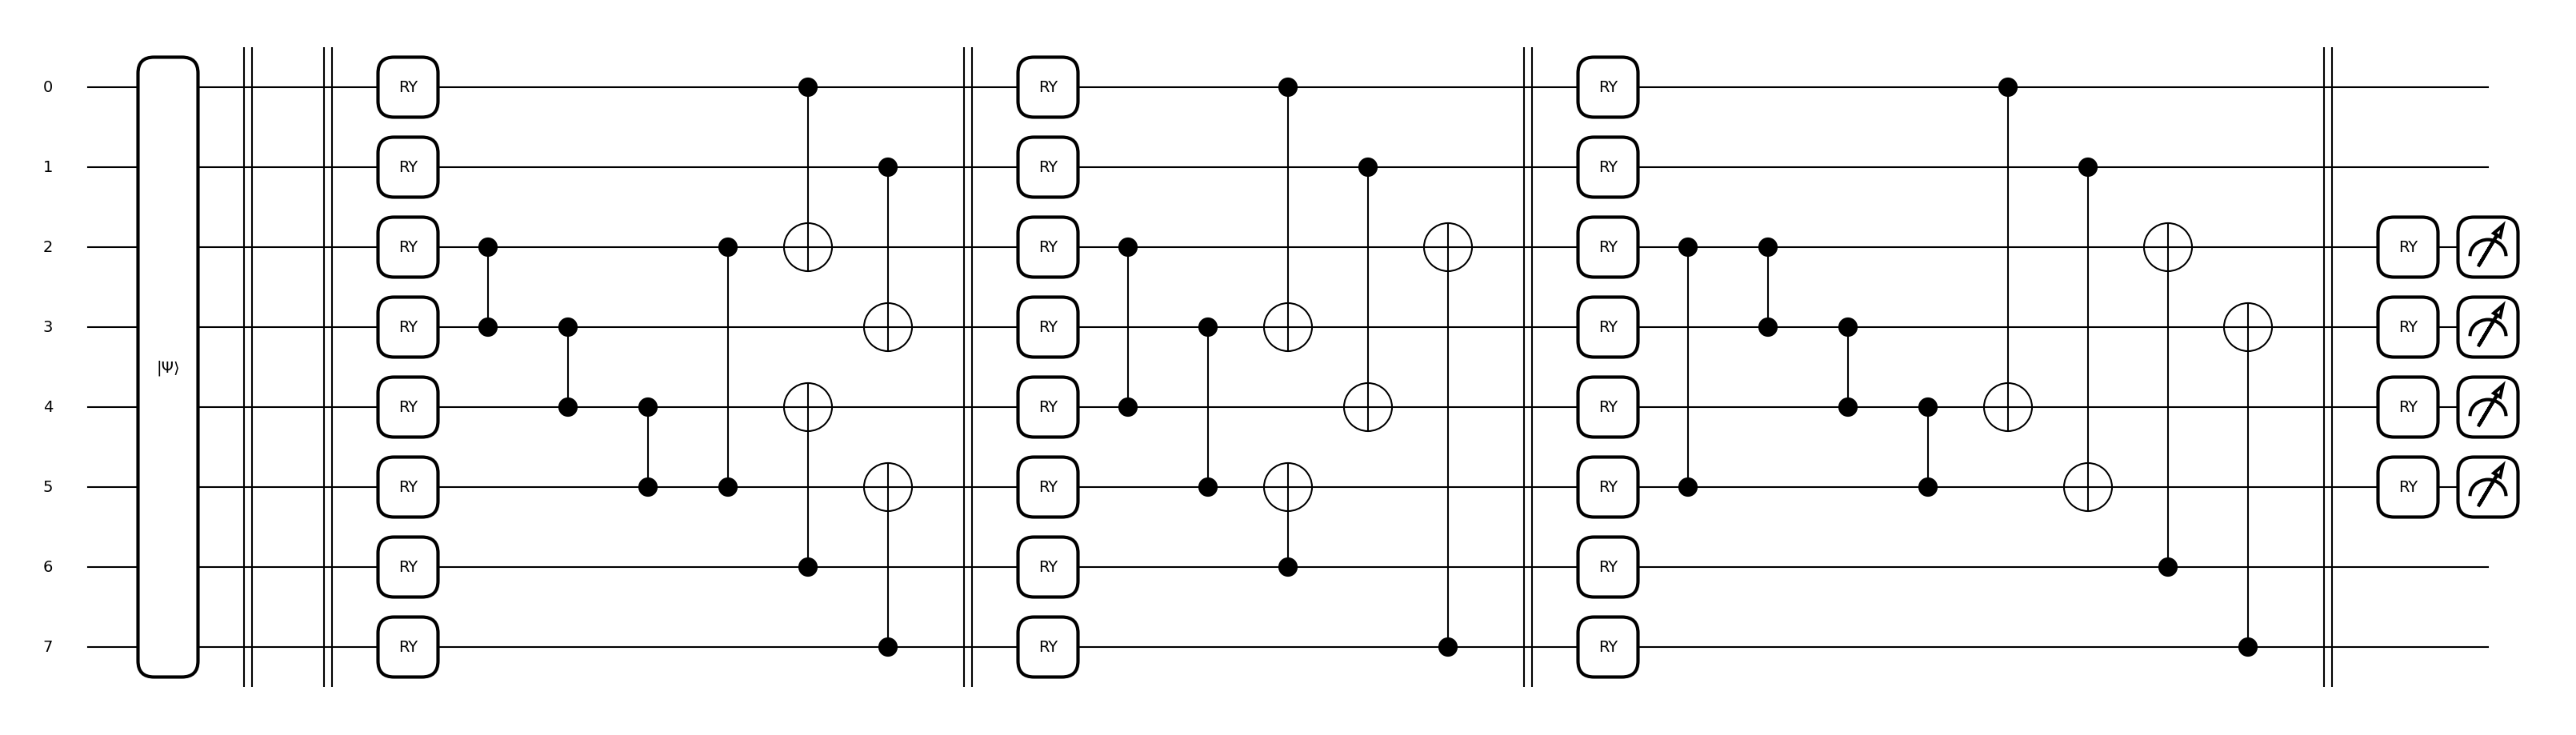

In [8]:
anomaly_model = anomaly_detection.Ad(n_qubit = n_qubit, side = side, vqeclass = vqe_model)
anomaly_model.show(mpl=True)

In [9]:
n_epoch = 300 # Number of epochs of the compression routine
lr = 1e-2     # Learning rate of the optimizer
h, k = 0, 0   # h and k values of the single input wavefunction (0, 0 == bottom left corner)

anomaly_model.train(n_epoch = n_epoch, lr = lr, h = h, k = k)

COST: -0.0000: 100%|██████████| 300/300 [00:05<00:00, 57.88it/s]


The QAE model is trained so that it compresses the input state optimally, leading to a low *compression score*.

After training, each state of the phase diagram is compressed through anomaly detection, and the corresponding cost value is assigned.

This approach does not require the model to be explicitly provided with information about the phases. However, based on the model's output for each state in the phase diagram, it is possible to infer both the number and the location of each phase.

Typically, states belonging to the same phase as the training event undergo optimal compression due to their inherent similarity. Conversely, states from other phases tend to exhibit higher values in the cost function.

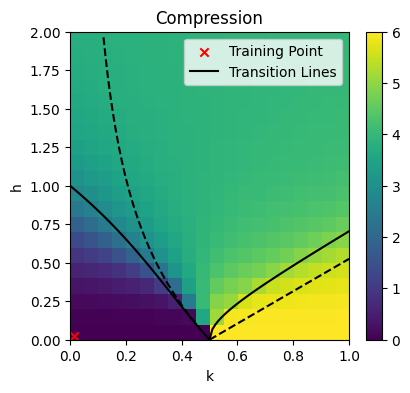

In [10]:
anomaly_model.predict() # Get the compression score of every input state

 We can see how the compression scores remain consistent within each phase, enabling a clear outline of all existing phases in the spin model.